In [1]:
from scipy import io
import mne
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# load case2225 raw data
loaded = io.loadmat('./raw_data/case_2225/case_2225_with_spike_dipoles_sleep_2.mat')

# get the peak time of each spike
peak_time = [loaded['Dipole_sleep_2'][0][i][1][0][0] for i in range(loaded['Dipole_sleep_2'].shape[1])] # second index -> # of peaks
print(peak_time)

[51.40829849243164, 51.52920150756836, 59.3567008972168, 59.471099853515625, 63.49100112915039, 69.77220153808594, 183.96279907226562, 201.55909729003906, 201.67919921875, 211.49789428710938, 211.6392059326172, 211.7563934326172, 238.06390380859375, 238.1851043701172, 251.71600341796875, 266.13189697265625, 266.2515869140625, 266.36590576171875, 343.6485900878906, 345.0425109863281, 345.1932067871094, 402.5203857421875, 402.6460876464844, 402.7771911621094, 405.43060302734375, 416.2991027832031, 416.41680908203125, 417.10430908203125, 456.5292053222656, 456.6466979980469, 471.0910949707031, 471.2004089355469, 471.3251037597656, 504.7976989746094, 504.9291076660156]


In [3]:
# raw data shape: 373 * 509000, we only care about the first 306 rows which represent MEG data. 509000 is the time domain (ms).
data = loaded['data_raw']
print(data.shape)

(373, 509000)


In [4]:
# filter the data use bandpass filter (1hz to 100hz).
data_filtered = mne.filter.filter_data(data, 1000, 1, 100)

Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 373 out of 373 | elapsed:    4.1s finished


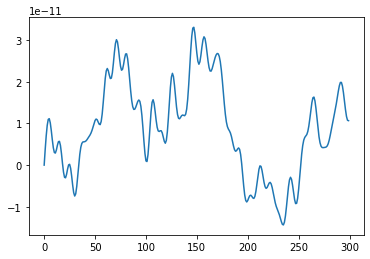

In [5]:
# see an example of filtered data (first channel, first 300 ms)
plt.plot(data_filtered[0][:300])

In [6]:
with open('channel_name.txt', 'r') as f:
    content = f.readline()
content = content.split('	')
content = [s.strip('\'').strip('MEG') for s in content]
channel_name_pair = [(i, content[i]) for i in range(len(content))]
channel_name_pair_inv = [(content[i], i) for i in range(len(content))]
# create two dictionary: channel_name_dict: channel index -> channel name, channel_name_dict_inv: channel name -> channel index
channel_name_dict = dict(channel_name_pair)
channel_name_inv_dict = dict(channel_name_pair_inv)

In [7]:
# divide channels into 8 groups based on brain anatonic structure. # labeled manually
channel_grouping = {
    "LF": ['0121', '0122', '0123', '0311', '0312', '0313', '0341', '0342', '0343', '0321', '0322', '0323', '0511', '0512', '0513', '0541', '0542', '0543', '0331', '0332', '0333', '0521', '0522', '0523', '0531', '0532', '0533', '0611', '0612', '0613', '0641', '0642', '0643', '0821', '0822', '0823', '0621', '0622', '0623'],
    "RF": ['0811', '0812', '0813', '1011', '1012', '1013', '0911', '0912', '0913', '0941', '0942', '0943', '1021', '1022', '1023', '1031', '1032', '1033', '0921', '0922', '0923', '0931', '0932', '0933', '1241', '1242', '1243', '1211', '1212', '1213', '1231', '1232', '1233', '1221', '1222', '1223', '1411', '1412', '1413'],
    "LT": ['0111', '0112', '0113', '0131', '0132', '0133', '0211', '0212', '0213', '0221', '0222', '0223', '0141', '0142', '0143', '1511', '1512', '1513', '0241', '0242', '0243', '0231', '0232', '0233', '1541', '1542', '1543', '1521', '1522', '1523', '1611', '1612', '1613', '1621', '1622', '1623', '1531', '1532', '1533'],
    "LP": ['0411', '0412', '0413', '0421', '0422', '0423', '0631', '0632', '0633', '0441', '0442', '0443', '0431', '0432', '0433', '0711', '0712', '0713', '1811', '1812', '1813', '1821', '1822', '1823', '0741', '0742', '0743', '1631', '1632', '1633', '1841', '1842', '1843', '1831', '1832', '1833', '2011', '2012', '2013'],
    "RP": ['1041', '1042', '1043', '1111', '1112', '1113', '1121', '1122', '1123', '0721', '0722', '0723', '1141', '1142', '1143', '1131', '1132', '1133', '0731', '0732', '0733', '2211', '2212', '2213', '2221', '2222', '2223', '2241', '2242', '2243', '2231', '2232', '2233', '2441', '2442', '2443', '2021', '2022', '2023'], 
    "RT": ['1311', '1312', '1313', '1321', '1322', '1323', '1441', '1442', '1443', '1421', '1422', '1423', '1431', '1432', '1433', '1341', '1342', '1343', '1331', '1332', '1333', '2611', '2612', '2613', '2411', '2412', '2413', '2421', '2422', '2423', '2641', '2642', '2643', '2621', '2622', '2623', '2631', '2632', '2633'],
    "LO": ['1641', '1642', '1643', '1721', '1722', '1723', '1711', '1712', '1713', '1731', '1732', '1733', '1941', '1942', '1943', '1741', '1742', '1743', '1911', '1912', '1913', '1921', '1922', '1923', '1931', '1932', '1933', '2141', '2142', '2143', '2041', '2042', '2043', '2111', '2112', '2113'],
    "RO": ['2121', '2122', '2123', '2031', '2032', '2033', '2131', '2132', '2133', '2341', '2342', '2343', '2331', '2332', '2333', '2311', '2312', '2313', '2321', '2322', '2323', '2541', '2542', '2543', '2511', '2512', '2513', '2431', '2432', '2433', '2521', '2522', '2523', '2531', '2532', '2533']    
}
channel_grouping_inv = {}
for key in channel_grouping.keys():
    curr_lst = channel_grouping[key]
    for item in curr_lst:
        channel_grouping_inv[item] = key

In [8]:
# create groups based on index from 0 to 305
channel_grouping_index = {}
for key in channel_grouping.keys():
    channel_grouping_index[key] = []
    list_of_name = channel_grouping[key]
    for name in list_of_name:
        channel_grouping_index[key].append(channel_name_inv_dict[name])

In [9]:
# have a look at the dictionary
for key in channel_grouping_index.keys():
    print(f"group: {key}, length: {len(channel_grouping_index[key])}")

group: LF, length: 39
group: RF, length: 39
group: LT, length: 39
group: LP, length: 39
group: RP, length: 39
group: RT, length: 39
group: LO, length: 36
group: RO, length: 36


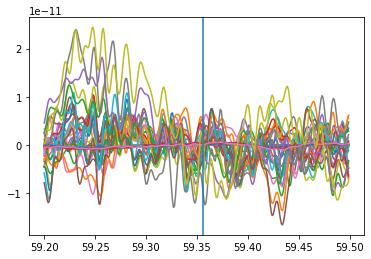

In [10]:
# example of a peak
for ind in channel_grouping_index["RF"]:
    plt.plot(loaded['time_raw'][0][59200:59500], data_filtered[ind][59200:59500])
plt.axvline(x = 59.356)

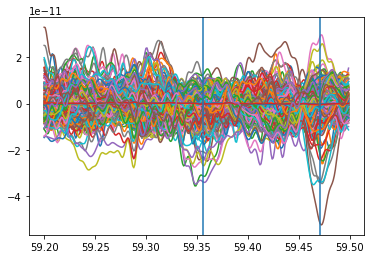

In [11]:
# example of two peaks
for key in channel_grouping_index.keys():
    for ind in channel_grouping_index[key]:
        plt.plot(loaded['time_raw'][0][59200:59500], data_filtered[ind][59200:59500])
plt.axvline(x = 59.356)
plt.axvline(x = 59.471)

In [41]:
import os
import random

data_folder_path = './raw_data'
data_paths_list = []

for single_folder_name in os.listdir(data_folder_path):
    single_folder_path = os.path.join(data_folder_path, single_folder_name)
    for single_file_name in os.listdir(single_folder_path):
        data_paths_list.append(os.path.join(single_folder_path, single_file_name))

In [19]:
peak_time_ms = [int(t * 1000) for t in peak_time]
peak_time_ms[0]

7697

In [20]:
channel_name_dict

{0: '0113',
 1: '0112',
 2: '0111',
 3: '0122',
 4: '0123',
 5: '0121',
 6: '0132',
 7: '0133',
 8: '0131',
 9: '0143',
 10: '0142',
 11: '0141',
 12: '0213',
 13: '0212',
 14: '0211',
 15: '0222',
 16: '0223',
 17: '0221',
 18: '0232',
 19: '0233',
 20: '0231',
 21: '0243',
 22: '0242',
 23: '0241',
 24: '0313',
 25: '0312',
 26: '0311',
 27: '0322',
 28: '0323',
 29: '0321',
 30: '0333',
 31: '0332',
 32: '0331',
 33: '0343',
 34: '0342',
 35: '0341',
 36: '0413',
 37: '0412',
 38: '0411',
 39: '0422',
 40: '0423',
 41: '0421',
 42: '0432',
 43: '0433',
 44: '0431',
 45: '0443',
 46: '0442',
 47: '0441',
 48: '0513',
 49: '0512',
 50: '0511',
 51: '0523',
 52: '0522',
 53: '0521',
 54: '0532',
 55: '0533',
 56: '0531',
 57: '0542',
 58: '0543',
 59: '0541',
 60: '0613',
 61: '0612',
 62: '0611',
 63: '0622',
 64: '0623',
 65: '0621',
 66: '0633',
 67: '0632',
 68: '0631',
 69: '0642',
 70: '0643',
 71: '0641',
 72: '0713',
 73: '0712',
 74: '0711',
 75: '0723',
 76: '0722',
 77: '072

In [60]:
# load the data, get peak time
loaded = io.loadmat('./raw_data/case_2225/case_2225_with_spike_dipoles_sleep_4.mat')
peak_time = [loaded['Dipole_sleep_4'][0][i][1][0][0] for i in range(loaded['Dipole_sleep_4'].shape[1])] # second index -> # of peaks
peak_time_ms = [int(t * 1000) for t in peak_time]
data_MEG = loaded['data_raw']
data_MEG_filtered = mne.filter.filter_data(data_MEG, 1000, 1, 100)

Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 373 out of 373 | elapsed:    5.5s finished


In [57]:
# loop through peak time
positive_samples = []
negative_samples = []
for p in peak_time_ms:
    # identify region
    region = None
    max_ind = 0
    max_num = 0
    for i in range(306):
        if abs(data_MEG_filtered[i][p]) > max_num:
            max_num = abs(data_MEG_filtered[i][p])
            max_ind = i
    region = channel_grouping_inv[channel_name_dict[max_ind]]
    for i in np.arange(p-220, p-80, 5):
        positive_samples.append(data_MEG_filtered[channel_grouping_index[region], i:i+300])
while len(negative_samples) < len(positive_samples):
    random_group = random.choice(list(channel_grouping_index.keys()))
    random_num = random.randint(300, data_MEG_filtered.shape[1] - 300)
    for p in peak_time_ms:
        if p < random_num or p > random_num + 300:
            negative_samples.append(data_MEG_filtered[channel_grouping_index[random_group], random_num:random_num+300])
returned_data = positive_samples + negative_samples
returned_label = [1] * len(positive_samples) + [0] * len(negative_samples)

dict_keys(['LF', 'RF', 'LT', 'LP', 'RP', 'RT', 'LO', 'RO'])

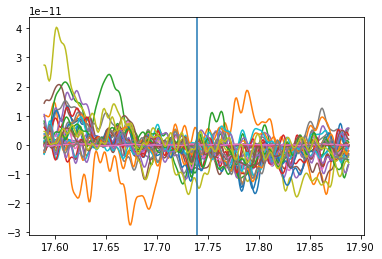

In [17]:
# example of a peak
x = peak_time[4]
l = int(x*1000) - 150
r = int(x*1000) + 150
for ind in channel_grouping_index["LF"]:
    plt.plot(loaded['time_raw'][0][l:r], data_filtered[ind][l:r])
plt.axvline(x)
channel_grouping_index.keys()

dict_keys(['LF', 'RF', 'LT', 'LP', 'RP', 'RT', 'LO', 'RO'])

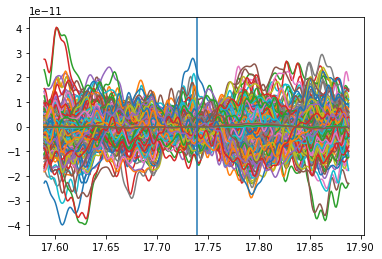

In [18]:
# example of a peak
x = peak_time[4]
l = int(x*1000) - 150
r = int(x*1000) + 150
for ind in range(306):
    plt.plot(loaded['time_raw'][0][l:r], data_filtered[ind][l:r])
plt.axvline(x)
channel_grouping_index.keys()

In [66]:
def acc(label, output):
    return np.mean(label == output)
acc(np.array([1, 2, 3]), np.array([1, 3, 3]))

0.6666666666666666